In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Load test data.

In [2]:
# Load test data
test_path = "/home/elek/projects/splicing/results/data_processing_subset/processed_data_test.npz"
data = np.load(test_path)

test_sequences = data['sequences']
test_labels = data['labels']

test_sse = data['usage_sse']
test_alpha = data['usage_alpha']
test_beta = data['usage_beta']

test_sse = np.nan_to_num(test_sse, nan=0.0)
test_alpha = np.nan_to_num(test_alpha, nan=0.0)
test_beta = np.nan_to_num(test_beta, nan=0.0)

print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test usage shape: {test_sse.shape}")
print(f"Test alpha shape: {test_alpha.shape}")
print(f"Test beta shape: {test_beta.shape}")

Test sequences shape: (58097, 10000, 4)
Test labels shape: (58097, 1000)
Test usage shape: (58097, 1000, 4)
Test alpha shape: (58097, 1000, 4)
Test beta shape: (58097, 1000, 4)


Load predictions.

In [ ]:
# Load the model predictions from a file
pred_path = "/home/elek/projects/splicing/results/predictions/test_predictions_small_resnet.npz"
pred = np.load(pred_path)

# Keys in the loaded data
print(f"Available keys: {list(pred.keys())}")
for key in pred.keys():
    print(f"{key}: {pred[key].shape}")

pred_preds = pred['splice_predictions']
pred_probs = pred['splice_probs']

Available keys: ['splice_predictions', 'splice_probs', 'usage_alpha', 'usage_beta', 'usage_sse', 'labels_true', 'usage_alpha_true', 'usage_beta_true', 'usage_sse_true']
splice_predictions: (58097, 1000)
splice_probs: (58097, 1000, 3)
usage_alpha: (58097, 1000, 4)
usage_beta: (58097, 1000, 4)
usage_sse: (58097, 1000, 4)
labels_true: (58097, 1000)
usage_alpha_true: (58097, 1000, 4)
usage_beta_true: (58097, 1000, 4)
usage_sse_true: (58097, 1000, 4)


Inspect predictions vs true labels for the first few sequences.

In [5]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_preds[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(test_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_preds[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       []
  predicted    [1, 20, 72, 122, 177, 284, 313, 334, 462, 596, 607, 611, 622, 701, 717, 742, 789, 804, 902, 956, 968, 971, 989]
(2) Acceptor splice sites in sequence 0:
  actual    [0]
  predicted [0, 19, 71, 86, 97, 193, 199, 266, 267, 299, 312, 333, 403, 419, 420, 454, 461, 517, 562, 571, 595, 610, 619, 680, 682, 687, 704, 773, 800, 854, 858, 955, 970]

(1) Donor splice sites in sequence 1:
  actual       [0, 788]
  predicted    [0, 9, 14, 36, 52, 60, 73, 80, 103, 120, 204, 225, 238, 260, 262, 333, 382, 412, 418, 434, 442, 495, 508, 513, 518, 520, 561, 588, 605, 612, 639, 656, 671, 694, 711, 719, 763, 776, 788, 792, 882, 884, 891, 895, 919, 947, 963, 974]
(2) Acceptor splice sites in sequence 1:
  actual    []
  predicted [8, 13, 51, 55, 64, 76, 79, 91, 100, 102, 107, 119, 134, 143, 151, 154, 222, 267, 279, 297, 310, 325, 343, 372, 375, 381, 392, 402, 409, 411, 417, 427, 451, 454, 456, 459, 465, 470, 476, 479, 494, 498, 507, 524

In [ ]:
for i, j in [(0, 1), (0, 19), (1, 8), (1, 9)]:
    print(f"Sequence {i}, position {j}:\n  true label: {test_labels[i,j]}\n  pred label: {pred_preds[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 1:
  true label: 0
  pred label: 1
  porbs:[0.02844799 0.9528032  0.01874878]
Sequence 0, position 19:
  true label: 0
  pred label: 2
  porbs:[0.28909478 0.19011058 0.52079463]
Sequence 1, position 8:
  true label: 0
  pred label: 2
  porbs:[0.28768092 0.11547947 0.59683967]
Sequence 1, position 9:
  true label: 0
  pred label: 1
  porbs:[0.1815133  0.74329156 0.07519514]


Calculate PR-AUC, the area under the precision-recall curve.

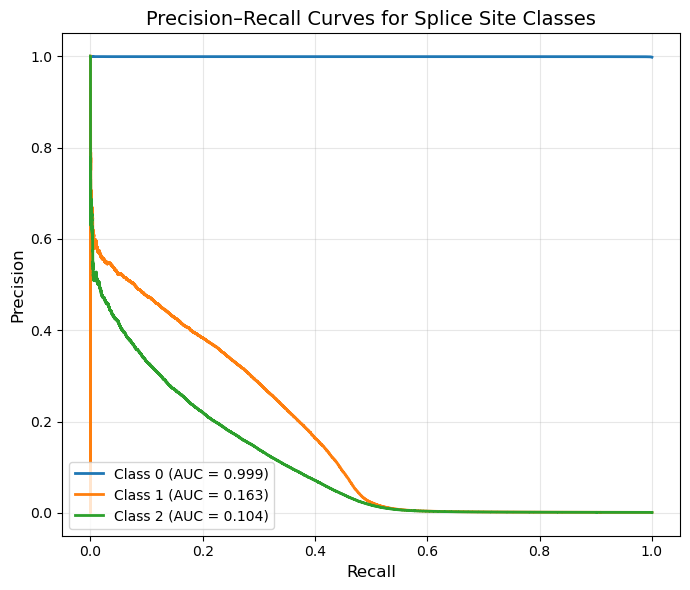

PR-AUC for class 0: 0.9990
PR-AUC for class 1: 0.1630
PR-AUC for class 2: 0.1036


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(7, 6))

for class_idx in range(3):
    # Binary labels for the current class
    y_true = (pred['labels_true'] == class_idx).astype(int).reshape(-1)
    # Predicted probabilities for that class
    y_scores = pred['splice_probs'][:, :, class_idx].reshape(-1)

    # Compute PR curve and area
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    # Plot
    plt.plot(
        recall, precision,
        label=f"Class {class_idx} (AUC = {pr_auc:.3f})",
        linewidth=2
    )

# Plot formatting
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print PR-AUC values
for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for class {c}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [9]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    y_true = (pred['labels_true'] == class_idx).astype(int)
    y_true = y_true.reshape(-1)
    y_scores = pred['splice_probs'][:,:,class_idx]
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.9984
Top-k accuracy for class 1: 0.2926
Top-k accuracy for class 2: 0.2096
